# Introduction

Now that we have reduced the raw images from the TRAPPIST telescope, our goal is to detect the transit in the light curve and model it. For this part of the workshop we will model the light curve from another night, where the transit of TRAPPIST-1d has been first observed.

While it seems obvious in our data, transit signals can often be lost in correlated noise such as instrumental systematics and stellar variability. Let's visualize our data

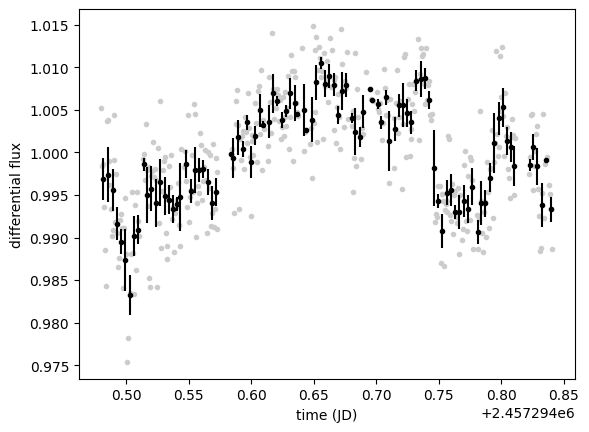

In [10]:
from prose import Fluxes
import matplotlib.pyplot as plt

# this is the second dataset
data = Fluxes.load("../data/TRAPPIST-South_20150928_UCDTS-48_I+z.flux")

ax = plt.subplot(xlabel="time (JD)", ylabel="differential flux")
data.plot()
data.bin(5 / 60 / 24, estimate_error=True).errorbar()

As you can see, we might have observed a transit signal, but it is not clear what part of the light curve contains instrumental signal. To help us, here are some of the other instrumental signals we recorded along our observation:

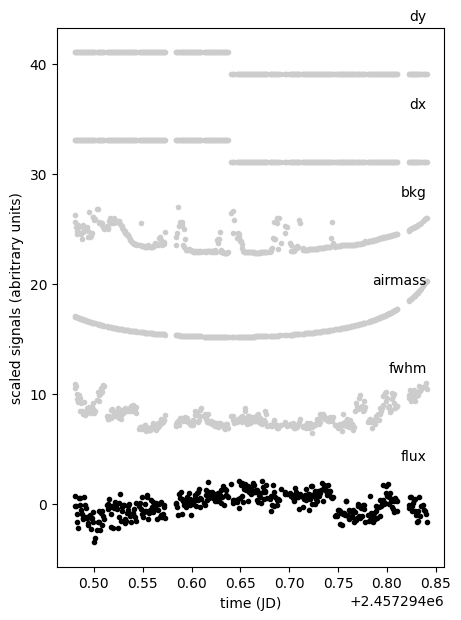

In [11]:
import numpy as np

plt.figure(None, (5, 7))
ax = plt.subplot(xlabel="time (JD)", ylabel="scaled signals (abritrary units)")

for i, name in enumerate(["flux", "fwhm", "airmass", "bkg", "dx", "dy"]):
    y = data.df[name].copy()
    y = (y - np.mean(y)) / np.std(y) + 8 * i
    plt.text(data.time.max(), np.mean(y) + 4, name, ha="right")
    plt.plot(data.time, y, ".", c="0.8" if name != "flux" else "k")

A common approach is to consider that the light curve can be modeled as a linear combination of these signals as explanatory variables, such as sky background, FWHM or airmass. Hence, we would model the light curve as:

$$f = X\omega$$

where the row of the columns of the design matric $X$, contains some explatanory variables.

**1. Define the design matrix $X$ and solve for w**

In [12]:
import numpy as np

X = np.vstack(
    [
        data.data["airmass"],
        data.data["fwhm"],
        data.data["bkg"],
        data.data["dx"],
        data.data["dy"],
    ]
)

# normalizing
X = (X - np.mean(X, axis=1)[:, None]) / np.std(X, axis=1)[:, None]

# adding a constant baseline
X = np.vstack([X, np.ones(X.shape[1])])

Let's find the least squares solution of the equation previously defined and see if this model can explain the signal well

In [13]:
w = np.linalg.lstsq(X.T, data.flux, rcond=None)[0]

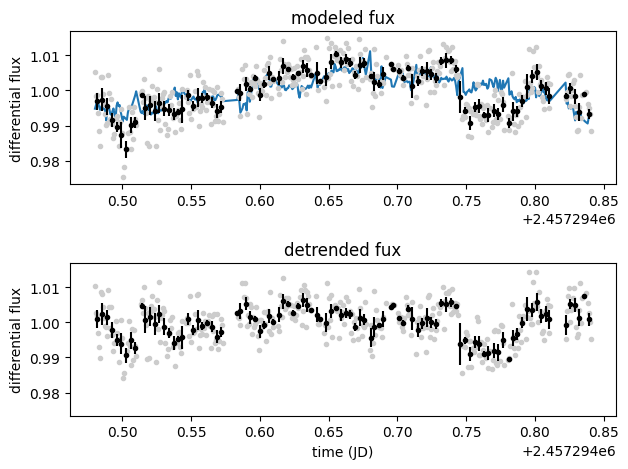

In [14]:
ax1 = plt.subplot(211, ylabel="differential flux", title="modeled fux")
ax1.plot(data.time, w @ X)
data.plot()
data.bin(5 / 60 / 24, estimate_error=True).errorbar()
ylim = ax1.get_ylim()

detrended_flux = data.copy()
detrended_flux.fluxes = detrended_flux.fluxes - w @ X + 1.0

ax2 = plt.subplot(
    212, xlabel="time (JD)", ylabel="differential flux", title="detrended fux"
)
detrended_flux.plot()
detrended_flux.bin(5 / 60 / 24, estimate_error=True).errorbar()
ax2.set_ylim(ylim)

plt.tight_layout()

While we can still see the transit, this approach can generally degrade the signal of interest. In the next notebook, we will learn how to use *nuance* to better detect the transits while taking into account this correlated noise.